# Contents
- [Imports](#imports)
- [Preliminary Test](#prelim)
- [Creating Our Test Video](#testcreate)
- [Visual Test](#vid)
- [Quantitative Test](#quantitative)
    - [Obtaining Test Keypoint](#keypoints)
    - [Classification on Test Keypoints](#keypointclass)

---
# Imports<a id=imports></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from inspect import signature
from itertools import cycle
from IPython.display import HTML
from IPython.display import Image
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, make_scorer, roc_curve, classification_report, precision_recall_curve, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

import argparse
import logging
import time
import os
import re
import cv2
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

C:\Users\chang\.conda\envs\opencv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\chang\.conda\envs\opencv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\chang\.conda\envs\opencv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\chang\.conda\envs\opencv\lib\site-packages\tensorflow\python\framework

---
# Preliminary Test<a id=prelim></a>
While investigating, a test was previously conducted where we tried to assess the ability of an AdaBoost classifier to classify jabs (note: This classifier had perfect accuracy in holdout testing).<br/>
The video is shown below.

In [2]:
def showvideo(i):
    display(HTML("""<video width="1500" height="1000" controls><source src="{}" type="video/mp4"></video>""".format(i)))
    
showvideo('../results/jab deploy/jab deploy.mp4')    

From our preliminary assessment, we can observe that our classification is highly dependant on the positions of our keypoints.<br/>
We say this due to the following observations:
1. A jab is classified based on the height of the outstretched arm.

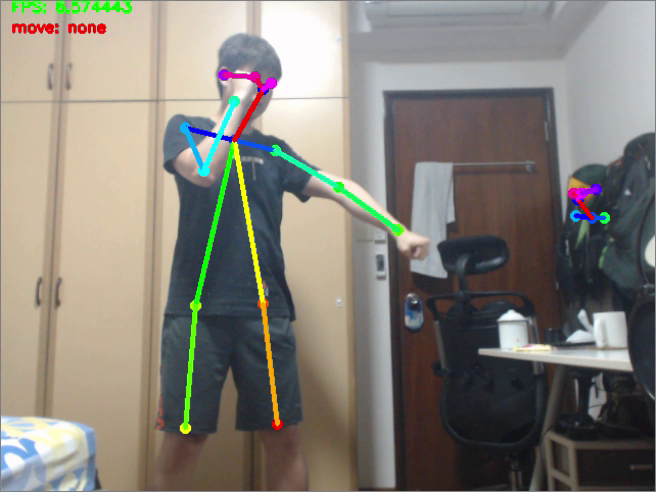

In [3]:
Image(filename='../results/jab deploy/low jab.png') 

2. A jab is classified based on the distance of the guard compared to the other keypoints.

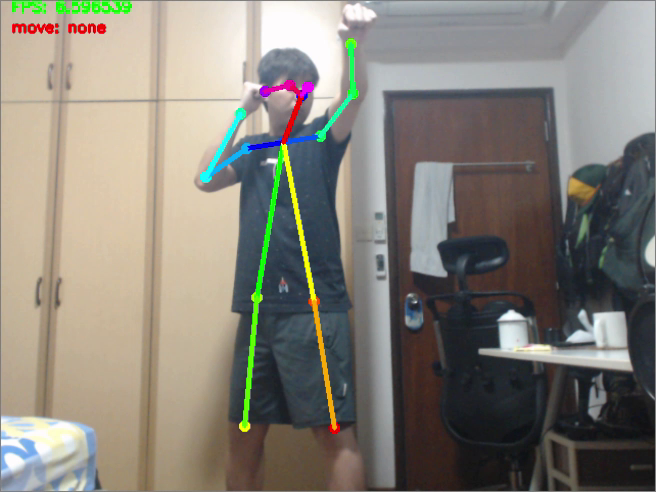

In [4]:
Image(filename='../results/jab deploy/wide guard.png') 

3. A jab is classified based only on the standing data created in our training set. (does not classify squatting postures)

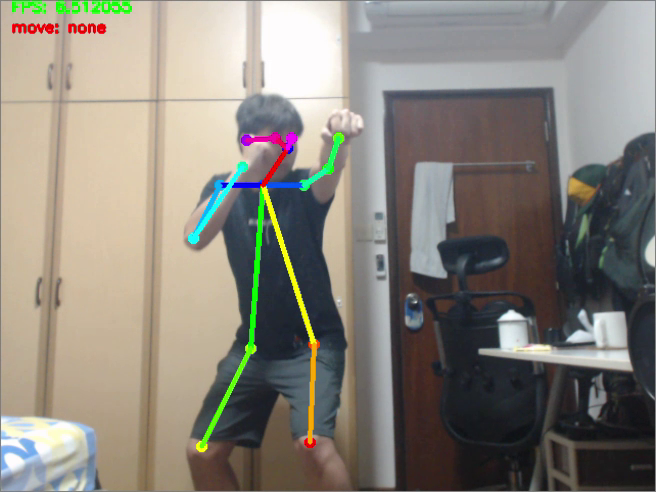

In [5]:
Image(filename='../results/jab deploy/squat jab.png') 

This implies that we have created a classifier that is usable provided that the distances, angles and movements are similar to those provided in our training set.<br/>
Such a classifier is ok for a baseline, however we would wish to create a 'smarter' classifier that can account for differences in distances, angles and movement for our final product.<br/>
We shall have a more rigorous testing method in the following sections.

---
# Creating our Test video <a id=testcreate></a>
For rigour and fairness, we shall be testing all our different pickled models on the same videos to analyze which kernels are suitable for our purposes.<br/>
In this vein, our next step would be to create a test video that will be used for testing all our pickled models.<br/><br/>
Our video will have to encompass our 6 classes: (1) not boxing, (2) guard, (3) jab, (4) cross, (5) hook, and (6) uppercut.<br/>
Our video will also have to account for differences in position, angle and movement.<br/>
As such, we will create a video in such a manner:
1. The video will start and end with a certain amount of non-boxing movements
2. We will then perform moves in a specific position and angle, for a certain movement pattern
3. The moves will be performed in this order: jab, cross, hook, uppercut
4. We will have the same 5 positions and 2 distances as we have specified in the creation of our training data
5. We will finish off by including forward and backward movement.

The video we created for testing purposes is shown below.

In [6]:
showvideo('../results/test.mp4')

Next, we shall run a visual test by deploying our previously pickled models and observing the classification our models output.

---
# Visual Test<a id=vid></a>
First, let us import the necessary code for our video tests.

In [3]:
logger = logging.getLogger('TfPoseEstimator-Video')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

fps_time = 0

In [4]:
parser = argparse.ArgumentParser(description='tf-pose-estimation Video')
parser.add_argument('--video', type=str, default='')
parser.add_argument('--resolution', type=str, default='432x368', help='network input resolution. default=432x368')
parser.add_argument('--model', type=str, default='mobilenet_thin', help='cmu / mobilenet_thin / mobilenet_v2_large / mobilenet_v2_small')
parser.add_argument('--show-process', type=bool, default=False,
                    help='for debug purpose, if enabled, speed for inference is dropped.')
parser.add_argument('--showBG', type=bool, default=True, help='False to show skeleton only.')

_StoreAction(option_strings=['--showBG'], dest='showBG', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, help='False to show skeleton only.', metavar=None)

We create a function that will take in a video and perform our keypoint estimation and prediction and output all of this information into another video.

In [5]:
def vidtest(args):
    
    fps_time = 0
    
    lis=[]
    for x in range(1,18):
        lis.append('x'+str(x))
        lis.append('y'+str(x))
    header=pd.DataFrame(columns=lis)
    
    logger.debug('initialization %s : %s' % (args.model, get_graph_path(args.model)))
    w, h = model_wh(args.resolution)
    e = TfPoseEstimator(get_graph_path(args.model), target_size=(w, h))
    cap = cv2.VideoCapture(args.video)

    if cap.isOpened() is False:
        print("Error opening video stream or file")
    while cap.isOpened():
        try:
            ret_val, image = cap.read()
            humans = e.inference(image, upsample_size=4.0)
        except:
            break
            
        if not args.showBG:
            image = np.zeros(image.shape)
        image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

        cv2.putText(image, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        move='none'

        try:
            part=re.findall('BodyPart:(.*?)-',str(humans[0]))
            xco=re.findall('\((.*?),',str(humans[0]))
            yco=re.findall(', (.*?)\)',str(humans[0]))
            xpart=['x'+c for c in part]
            ypart=['y'+c for c in part]
            test1=pd.DataFrame([[float(x) for x in xco+yco]],columns=xpart+ypart)
            data=pd.concat([header,test1],sort=True).fillna(0).to_numpy()

            predict=mod.predict(data) #perform a .predict based on our previously pickled models
            if predict[0]==0: #assign output text to our predicted classes
                move='none'
            elif predict[0]==1:
                move='guard'
            elif predict[0]==2:
                move='jab'
            elif predict[0]==3:
                move='cross'
            elif predict[0]==4:
                move='hook'
            elif predict[0]==5:
                move='uppercut'
            else:
                move='none'

        except: #provide exceptions if there are any modelling problems e.g. no humans detected
            move='not detected'

        finally:
            cv2.putText(image,
                        'move: '+move,
                        (10, 30),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 0, 255), 2)
            out.write(image) #output video with keypoint estimator and predictor text
            cv2.imshow('tf-pose-estimation result', image)
            fps_time = time.time()

            if cv2.waitKey(1) == 27:
                break
            
    cv2.destroyAllWindows()
    logger.debug('finished+')
    return(data)

For our video output, we set our video encoder to be 'mp4v'

In [25]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

The cell below is included to prevent any exceptions with GPU usage during our estimation and prediction processes.

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
#delete this later
args=parser.parse_args(("--video=../results/test.mp4 --model=cmu").split())
model='DecisionTree'
writepath="../results/test1/"+str(model)+".mp4"
out=cv2.VideoWriter(writepath, fourcc, 30, (1280,720))
mod=pickle.load(open(r'./data/model1/'+model+'.sav', 'rb'))
vidtest(args)

[2019-08-01 00:23:27,141] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-08-01 00:23:27,141] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
I0801 00:23:27.141107  1892 <ipython-input-5-10db75e22fd9>:11] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-08-01 00:23:27,146] [TfPoseEstimator] [INFO] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)
I0801 00:23:27.146096  1892 estimator.py:309] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)


Finally, we run a loop for all our pickled models where we perform our estimation and prediction, and we automatically save our output video to an external folder.

In [22]:
path='./data/model1/'
args=parser.parse_args(("--video=../results/test.mp4 --model=cmu").split())
for e_name in os.listdir(path):
    model=os.path.splitext(e_name)[0]
    writepath="../results/test1/"+str(model)+".mp4"
    out=cv2.VideoWriter(writepath, fourcc, 29.72, (1280,720))
    mod=pickle.load(open(r'./data/model1/'+e_name, 'rb'))
    vidtest(args)

[2019-07-31 21:26:35,204] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-07-31 21:26:35,204] [TfPoseEstimator-Video] [DEBUG] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
I0731 21:26:35.204653 11952 <ipython-input-9-10db75e22fd9>:11] initialization cmu : D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb
[2019-07-31 21:26:35,209] [TfPoseEstimator] [INFO] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)
I0731 21:26:35.209588 11952 estimator.py:309] loading graph from D:\Insync\Team Drive\amilame@gmail.com\amilame@gmail.com\HAR\tf-pose-estimation\models\graph/cmu/graph_opt.pb(default size=432x368)
[2019-07-31 21:33:10,911] [Tf

Shown below are all the video outputs for our pickled models, for our analysis purposes.

In [3]:
path='./data/model1/'
for e_name in os.listdir(path):
    model=os.path.splitext(e_name)[0]
    print('result of '+str(model)+':')
    showvideo('../results/test1/'+str(model)+'.mp4')

result of ADA:


result of bagging classifier:


result of DecisionTree:


result of ef:


result of GBoost:


result of knn:


result of lr with reg:


result of random forest:


result of SVC:


result of XGB:


Our models are lackluster, with certain models not capable of predicting certain moves like crosses, and the predictions being very jumpy during movements and even when the subject is stationary.

---
# Quantitative Test<a id=quantitative></a>

## Obtaining Test Keypoints<a id=keypoints></a>
To be more objective in our analysis, let us convert our test video into a dataframe to run our predictions on.<br/>
We perform the same steps as we did in our data collection section, splitting our video into 6 classes before getting the keypoints for our classes separately.


In [9]:
def video(args):
    
    fps_time = 0
    
    lis=[] # we create our empty dataframe in the function as a precaution
    for x in range(1,18):
        lis.append('x'+str(x))
        lis.append('y'+str(x))
    data=pd.DataFrame(columns=lis)
    
    logger.debug('initialization %s : %s' % (args.model, get_graph_path(args.model)))
    w, h = model_wh(args.resolution)
    e = TfPoseEstimator(get_graph_path(args.model), target_size=(w, h))
    cap = cv2.VideoCapture(args.video)

    if cap.isOpened() is False:
        print("Error opening video stream or file")
    while cap.isOpened():
        try:
            ret_val, image = cap.read()
            humans = e.inference(image, upsample_size=4.0)
        except:
            break
        try:
            part=re.findall('BodyPart:(.*?)-',str(humans[0])) #extract bodypart numbers to list 'part'
            xco=re.findall('\((.*?),',str(humans[0])) #extract x coordinates to list 'xco'
            yco=re.findall(', (.*?)\)',str(humans[0])) #extract y coordinates to list 'yco'
            xpart=['x'+c for c in part] #create column headers for x coordinates for each body part
            ypart=['y'+c for c in part] #create column headers for y coordinates for each body part
            test1=pd.DataFrame([xco+yco],columns=xpart+ypart) #create a dataframe of keypoints for this video frame
            data=pd.concat([data,test1],sort=True) #append keypoint information to previously created dataframe

        except:
            continue
        if not args.showBG:
            image = np.zeros(image.shape)
        image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

        cv2.putText(image, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.imshow('tf-pose-estimation result', image)
        fps_time = time.time()
        if cv2.waitKey(1) == 27:
            break
    
    data.to_csv(r'../results/test/'+re.search('t/(.*?).mp4',args.video).group(1)+'.csv', index=False) #output csv to 'test' folder, with csv name based on arguments specified
    cv2.destroyAllWindows()
    logger.debug('finished+')
    return(data)

We then run this function for our 6 cleaned videos to obtain 6 csv files which we use for modelling.

In [ ]:
args=parser.parse_args(("--video=../results/test/none.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../results/test/guard.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../results/test/jab.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../results/test/cross.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../results/test/hook.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../results/test/uppercut.mp4 --model=cmu").split())
video(args)

## Classification on Test Keypoints<a id=keypointclass></a>
With our keypoints extracted, the next thing we do is to give them classification labels and perform our predictions on our whole set of points.<br/>
We will display the classification matrix to observe the accuracy scores.<br/>

First, we load our keypoints to different dataframes based on their classes.

In [5]:
none=pd.read_csv('../results/test/none.csv')
guard=pd.read_csv('../results/test/guard.csv')
jab=pd.read_csv('../results/test/jab.csv')
cross=pd.read_csv('../results/test/cross.csv')
hook=pd.read_csv('../results/test/hook.csv')
upcut=pd.read_csv('../results/test/uppercut.csv')

Next, we assign their classes in a new feature

In [6]:
none['move']=0
guard['move']=1
jab['move']=2
cross['move']=3
hook['move']=4
upcut['move']=5

In [8]:
data=pd.concat([none,guard,jab,cross,hook,upcut],sort=True)
data.head()

,move,x0,x1,x10,x11,x12,x13,x14,x15,x16,...,y16,y17,y2,y3,y4,y5,y6,y7,y8,y9
0,0,0.75,0.69,NaN,0.63,0.67,NaN,0.75,NaN,0.71,...,0.12,NaN,0.26,0.54,0.79,0.27,NaN,NaN,0.68,0.90
1,0,0.75,0.68,NaN,0.62,0.63,NaN,0.75,NaN,0.71,...,0.13,NaN,0.26,0.53,0.79,0.27,NaN,NaN,0.67,0.88
2,0,0.74,0.68,NaN,0.63,0.66,NaN,0.74,NaN,0.70,...,0.13,NaN,0.26,0.52,0.79,0.27,NaN,NaN,0.67,0.89
3,0,0.74,0.67,NaN,0.62,0.64,NaN,0.74,NaN,0.70,...,0.14,NaN,0.26,0.52,0.78,0.27,NaN,NaN,0.69,0.91
4,0,0.73,0.67,NaN,0.63,NaN,NaN,0.73,NaN,0.69,...,0.14,NaN,0.27,0.52,0.78,0.27,NaN,NaN,0.69,0.91


We fill all NaN values with 0,

In [9]:
data.fillna(0,inplace=True)

And we perform our .predicts and obtain our classification report.

In [12]:
X=data[[x for x in data.columns if x != 'move']].to_numpy()
y=data['move']

In [13]:
path='./data/model1/'
for e_name in os.listdir(path):
    model=os.path.splitext(e_name)[0]
    estimator=pickle.load(open(r'./data/model1/'+e_name, 'rb'))
    pred=estimator.predict(X)
    print('Results for ',model,':')
    print(classification_report(y,pred))

Results for  ADA :
              precision    recall  f1-score   support

           0       0.47      0.62      0.53       926
           1       0.76      0.83      0.79      2271
           2       0.51      0.13      0.21       281
           3       0.00      0.00      0.00       195
           4       0.24      0.07      0.11       172
           5       0.08      0.08      0.08       155

    accuracy                           0.63      4000
   macro avg       0.34      0.29      0.29      4000
weighted avg       0.59      0.63      0.60      4000

Results for  bagging classifier :
              precision    recall  f1-score   support

           0       0.62      0.37      0.47       926
           1       0.91      0.79      0.85      2271
           2       0.37      0.22      0.28       281
           3       0.09      0.03      0.05       195
           4       0.24      0.34      0.28       172
           5       0.11      0.69      0.19       155

    accuracy            

Our best accuracy score is 65% for Gradient Boosting, with the rest of the scores hovering between 40 to 60%.<br/>
This is a far cry from our training and holdout results and this lackluster performance can be attributed to either overfitting, or to the methods the kernels use in their classification methods.<br/>

Let us analyze our dataset and perform some feature engineering next.